In [226]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (12, 4)

In [88]:
#pip install -U statsmodels
import statsmodels.api as sm 

#  Analisis exploratorio ultimos 6 meses año 2017

El analisis exploratorio que se presenta a continuacion tiene como fin determinar que feathers influyen en mayor medida a la hora de determinar el precio de un inmueble en Capital Federal y Gran Buenos Aires, asi como tambien encontrar datos curiosos en el data set.

Los datos fueron provistos por [Properati](http://www.properati.com.ar) y reorganizo en un solo dataset de la siguiente manera : [GitHub | properati_argentina](https://github.com/BraianVicente/properati_argentina/blob/master/src/TP1%20-%20Properati%20-%20Parseo%20de%20datos%20por%20fecha.ipynb)

In [89]:
sell_properati = pd.read_csv('../data/properati_full_month.csv',low_memory=False)

In [90]:
sell_properati.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597228 entries, 0 to 597227
Data columns (total 31 columns):
country_name                  203235 non-null object
created_on                    597228 non-null object
currency                      499252 non-null object
description                   385325 non-null object
expenses                      28822 non-null object
extra                         164828 non-null object
floor                         81496 non-null float64
geonames_id                   503992 non-null float64
id                            220507 non-null object
image_thumbnail               579074 non-null object
lat                           476202 non-null float64
lat-lon                       476202 non-null object
lon                           476197 non-null float64
operation                     597228 non-null object
place_name                    597187 non-null object
place_with_parent_names       597228 non-null object
place_with_parent_names_l1    17272 non

Transformando el formato del feature created_on para manejarlo como fecha

In [91]:
sell_properati['created_on'] = sell_properati['created_on'].apply(lambda x : pd.to_datetime(x))

In [92]:
sell_properati['year'] = sell_properati['created_on'].apply(lambda x : x.year)

In [93]:
sell_properati.year.unique()

array([2017, 2014, 2016, 2015, 2013])

In [94]:
sell_properati['year_month'] = sell_properati.created_on.apply(lambda x: str(x.year) + '-' + str(x.month))

In [95]:
sell_properati.year_month.unique()

array(['2017-1', '2014-1', '2016-1', '2014-8', '2016-8', '2014-4',
       '2016-3', '2015-12', '2017-5', '2015-4', '2016-12', '2013-8',
       '2017-4', '2015-10', '2014-11', '2016-5', '2016-10', '2016-4',
       '2015-6', '2017-6', '2015-1', '2015-5', '2014-6', '2015-9',
       '2014-12', '2013-9', '2014-3', '2015-3', '2014-5', '2015-7',
       '2016-9', '2016-7', '2014-10', '2016-6', '2015-11', '2016-2',
       '2016-11', '2015-2', '2017-3', '2014-7', '2013-10', '2017-2',
       '2013-12', '2015-8', '2014-9', '2013-11', '2014-2'], dtype=object)

In [96]:
sell_properati.place_with_parent_names.sample()

538689    |Argentina|Capital Federal|Villa del Parque|
Name: place_with_parent_names, dtype: object

In [97]:
sell_properati.country_name.unique()

array(['Argentina', nan, 'Uruguay', 'Brasil', 'Estados Unidos'], dtype=object)

In [98]:
sell_properati['state_name'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[2])

In [99]:
sell_properati = sell_properati[
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Norte' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Sur' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Oeste' ) |
    (sell_properati['state_name'] == 'Capital Federal' ) 
    ]

In [101]:
sell_properati['zone'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[3])

In [102]:
sell_properati.shape

(416685, 34)

Filtramos por los datos que son reelevantes para nuestro analisis, obteniendo unicamente las propiedades de GBA y capital federal

In [103]:
sell_properati.country_name.unique()

array(['Argentina'], dtype=object)

In [104]:
sell_properati.columns

Index([u'country_name', u'created_on', u'currency', u'description',
       u'expenses', u'extra', u'floor', u'geonames_id', u'id',
       u'image_thumbnail', u'lat', u'lat-lon', u'lon', u'operation',
       u'place_name', u'place_with_parent_names',
       u'place_with_parent_names_l1', u'place_with_parent_names_l2', u'price',
       u'price_aprox_local_currency', u'price_aprox_usd', u'price_per_m2',
       u'price_usd_per_m2', u'properati_url', u'property_type', u'rooms',
       u'state_name', u'surface_covered_in_m2', u'surface_in_m2',
       u'surface_total_in_m2', u'title', u'year', u'year_month', u'zone'],
      dtype='object')

In [105]:
sell_properati.drop(inplace=True,\
    labels=['country_name','description','extra','id', u'image_thumbnail','operation'\
            ,'place_with_parent_names_l1','place_with_parent_names_l2', 'properati_url','surface_in_m2','title',\
           ],axis=1)

In [106]:
sell_properati[sell_properati['zone'] == ''][['lon','lat','place_with_parent_names','place_name']].shape

(23727, 4)

Podemos seguir trabajando con los datos que no cuentan con la informacion de Zona utilizando la ubicacion para identificarlos segun el barrio al que pertenecen pero en esta ocacion decidimos dejarlos de lado pues no son una cantidad significativa de datos

In [107]:
sell_properati[(pd.isnull(sell_properati['place_name']))].zone.unique()

array(['Tigre'], dtype=object)

#### Las propiedades del tigre son las unicas que no contienen informacion en 'place_name'

In [108]:
sell_properati.loc[pd.isnull(sell_properati['place_name']),'place_name'] = sell_properati.place_name.apply(lambda x : x if pd.notnull(x) else 'Tigre' )

In [109]:
sell_properati[(pd.isnull(sell_properati['place_name']))].zone.unique()

array([], dtype=object)

In [110]:
sell_properati = sell_properati[sell_properati['zone'] != '']

In [111]:
sell_properati.property_type.unique()

array(['house', 'apartment', 'store', 'PH'], dtype=object)

In [112]:
sell_properati.shape

(392958, 23)

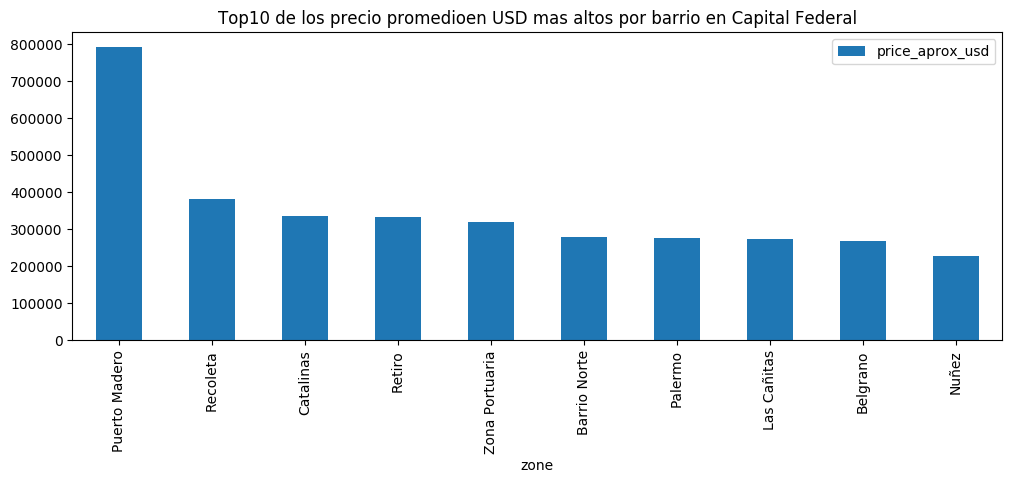

In [113]:
sell_properati[   (sell_properati['property_type'] == 'apartment') & \
                  (sell_properati['state_name'] == 'Capital Federal' )
              ].groupby(by='zone').mean()\
                .reset_index().sort_values(by='price_aprox_usd',ascending=False).head(10)\
                .plot.bar(y='price_aprox_usd',x='zone',title='Top10 de los precio promedioen USD mas altos por barrio en Capital Federal')

In [114]:
sell_properati[   (sell_properati['property_type'] == 'apartment') & \
                  (sell_properati['state_name'] != 'Capital Federal' )
              ].groupby(by='place_name').mean()\
                .reset_index().sort_values(by='price_aprox_usd',ascending=False).head(10)

,place_name,floor,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,rooms,surface_covered_in_m2,surface_total_in_m2,year
10,Bahía del Sol,NaN,NaN,-34.442026,-58.569832,5.350000e+05,6676772.500,535000.000000,3562.500000,NaN,3.500000,160.000000,NaN,2015.000000
178,Martindale Country Club,NaN,NaN,-34.471018,-58.872665,5.250000e+05,8383462.500,525000.000000,1859.505617,1859.505617,1.666667,278.333333,278.333333,2017.000000
25,Barrio El Yacht,NaN,NaN,-34.387715,-58.649760,4.825000e+05,7786488.750,482500.000000,3444.290466,3169.224636,2.666667,148.250000,159.000000,2016.000000
4,Albanueva Barrio Cerrado,1.0,NaN,-34.410455,-58.608642,4.617000e+05,6372134.950,461700.000000,2926.997807,2590.702598,3.285714,271.285714,299.142857,2015.800000
171,Manuel Alberti,1.0,NaN,-34.449026,-58.752826,3.926119e+06,4518858.788,439924.420222,25316.735834,25299.318875,1.928571,63.954545,84.571429,2015.574468
80,Country Saint Thomas,NaN,NaN,-34.885831,-58.502487,4.200000e+05,6781320.000,420000.000000,NaN,500.000000,NaN,NaN,840.000000,2017.000000
21,"Barrio Cerrado ""Sausalito""",NaN,NaN,-34.455906,-58.908329,3.750000e+05,6010912.500,375000.000000,1013.513514,1013.513514,1.000000,370.000000,370.000000,2017.000000
29,Barrio Lagos del Golf 1,NaN,NaN,-34.360001,-58.597000,3.500000e+05,3299135.000,350000.000000,NaN,NaN,NaN,NaN,NaN,2015.000000
77,Country Farm Club,NaN,NaN,-34.434415,-58.827270,3.500000e+05,5385872.000,350000.000000,2002.116402,1955.555556,2.333333,218.333333,275.000000,2016.000000
174,Manzone,NaN,3430876.0,-34.412501,-58.847888,3.437650e+05,5550429.690,343765.000000,4645.472973,3657.074468,3.000000,74.000000,94.000000,2017.000000


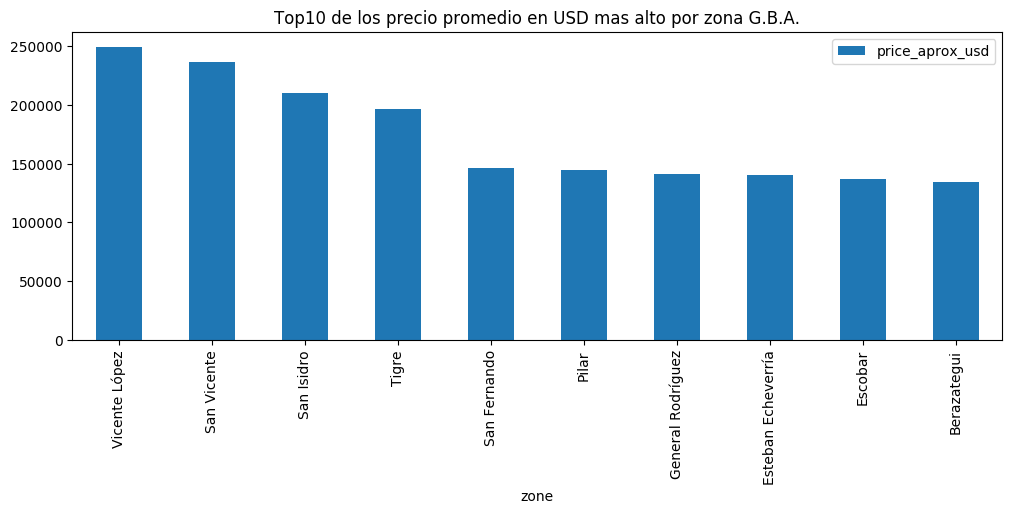

In [115]:
sell_properati[   (sell_properati['property_type'] == 'apartment') & \
                  (sell_properati['state_name'] != 'Capital Federal' )
              ].groupby(by='zone').mean()\
                .reset_index().sort_values(by='price_aprox_usd',ascending=False).head(10)\
                .plot.bar(y='price_aprox_usd',x='zone',title='Top10 de los precio promedio en USD mas alto por zona G.B.A.')

### A continuacion vamos a trabajar con los precios de las propiedades

In [116]:
price_sell_properati = sell_properati[['place_name','property_type','currency','price','price_aprox_local_currency','price_aprox_usd',\
                                       'surface_total_in_m2','surface_covered_in_m2','price_per_m2','price_usd_per_m2']]

In [117]:
price_sell_properati.shape

(392958, 10)

In [118]:
price_sell_properati.count()

place_name                    392958
property_type                 392958
currency                      348077
price                         351194
price_aprox_local_currency    351192
price_aprox_usd               351192
surface_total_in_m2           113437
surface_covered_in_m2         138470
price_per_m2                  126194
price_usd_per_m2              235631
dtype: int64

In [119]:
price_sell_properati[pd.isnull(price_sell_properati['currency'])].sample(5)

,place_name,property_type,currency,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_per_m2,price_usd_per_m2
37949,Caballito,apartment,NaN,NaN,NaN,NaN,33.0,33.0,NaN,NaN
249412,Flores,apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576978,Los Hornos,apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258797,Caseros,apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
573105,Pilar,apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
price_sell_properati[pd.isnull(price_sell_properati['currency'])].count()

place_name                    44881
property_type                 44881
currency                          0
price                          3117
price_aprox_local_currency     3117
price_aprox_usd                3117
surface_total_in_m2            9863
surface_covered_in_m2          9826
price_per_m2                      0
price_usd_per_m2                 11
dtype: int64

Debemos excluir los datos que tienen no tienen datos sobre 'currency' ya que no nos brindan ninguna informacion y ademas afecta el resultado real puesto que no tienen datos sobre el precio y la superficie por lo cual no se pueden sacar muchas conclusiones de esto.

In [121]:
price_sell_properati = price_sell_properati[pd.notnull(price_sell_properati['currency'])]

In [122]:
price_sell_properati[pd.isnull(price_sell_properati['price']) ].shape[0]

0

In [123]:
price_sell_properati[pd.isnull(price_sell_properati['price_aprox_local_currency']) ].shape[0]

2

In [124]:
price_sell_properati[pd.isnull(price_sell_properati['price_aprox_usd']) ].shape[0]

2

In [125]:
price_sell_properati[pd.isnull(price_sell_properati['surface_total_in_m2']) ].shape[0]

244503

In [126]:
price_sell_properati[pd.isnull(price_sell_properati['surface_covered_in_m2']) ].shape[0]

219433

In [127]:
price_sell_properati[pd.isnull(price_sell_properati['price_per_m2']) ].shape[0]

221883

In [128]:
price_sell_properati[pd.isnull(price_sell_properati['price_usd_per_m2']) ].shape[0]

112457

In [129]:
price_sell_properati[pd.isnull(price_sell_properati['price_per_m2']) ].groupby(by='currency').count()

,place_name,property_type,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_per_m2,price_usd_per_m2
currency,,,,,,,,,
ARS,22388,22388,22388,22386,22386,516,47,0,15353
BRL,2,2,2,2,2,0,0,0,0
USD,199493,199493,199493,199493,199493,6323,2403,0,128810


In [130]:
price_sell_properati.groupby(by='currency').count()

,place_name,property_type,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_per_m2,price_usd_per_m2
currency,,,,,,,,,
ARS,27412,27412,27412,27410,27410,4266,5071,5024,19030
BRL,2,2,2,2,2,0,0,0,0
USD,320663,320663,320663,320663,320663,99308,123573,121170,216590


 Queremos estudiar el precio en dolares de los inmuebles por lo cual la informacion que mas nos interesa es **price, price_aprox_usd, price_per_m2, surface_total_in_m2 y price_usd_por_m2 **, teniendo en cuenta estas 5 columna se podria completar gran parte de los datos para tener la mayor presicion posible al realizar el analisis exploratorio. 

Se van a filtrar los datos de los precios publicados en [PEN](https://es.wikipedia.org/w/index.php?title=Nuevo_sol) y en [BRL](https://es.wikipedia.org/wiki/Real_brasile%C3%B1o) ya que no aportan informacion sobre los metros cuadrados de las propiedades.

In [131]:
price_sell_properati = price_sell_properati[(price_sell_properati['currency'] == 'ARS') | (price_sell_properati['currency'] == 'USD') ]

In [132]:
price_sell_properati.count()

place_name                    348075
property_type                 348075
currency                      348075
price                         348075
price_aprox_local_currency    348073
price_aprox_usd               348073
surface_total_in_m2           103574
surface_covered_in_m2         128644
price_per_m2                  126194
price_usd_per_m2              235620
dtype: int64

In [133]:
#Calcula el precio la incognita (incognita = divisor/dividendo) para todo divisor mayor a cero y todo dividendo mayor a cero.

def dataframe_calc_value(df,incognita,divisor,dividendo):
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0)) ,incognita] = \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][divisor] / \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][dividendo]

### Se agrega la superficie total de los inmbuebles que disponen del precio por metro cuadrado en USD y el precio aproximado en USD

In [134]:
dataframe_calc_value(price_sell_properati,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que disponen del precio cuadrado en moneda actual y el precio aproximado en moneda actual

In [135]:
dataframe_calc_value(price_sell_properati,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que cuentan con el precio aproximado en USD y la superficie total en USD

In [136]:
dataframe_calc_value(price_sell_properati,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las propiedades que disponen de la cantidad total de metros cuadrados y el precio

In [137]:
dataframe_calc_value(price_sell_properati,'price_per_m2','price','surface_total_in_m2')

In [138]:
price_sell_properati.count()

place_name                    348075
property_type                 348075
currency                      348075
price                         348075
price_aprox_local_currency    348073
price_aprox_usd               348073
surface_total_in_m2           272241
surface_covered_in_m2         128644
price_per_m2                  272230
price_usd_per_m2              272230
dtype: int64

Se va a quitar la informacion que puede afectar el analisis de datos en los precios 

In [139]:
# Se quitan los datos que no cuenten con el precio o con la superficie total en metros cuadrados 
price_sell_properati = price_sell_properati[~((price_sell_properati['surface_total_in_m2'] == 0 ) | \
                     (price_sell_properati['price'] == 0 ))]

In [140]:
price_sell_properati.count()

place_name                    345991
property_type                 345991
currency                      345991
price                         345991
price_aprox_local_currency    345989
price_aprox_usd               345989
surface_total_in_m2           270356
surface_covered_in_m2         127305
price_per_m2                  270356
price_usd_per_m2              270356
dtype: int64

Ahora contamos con la informacion mucho mas completa y robusta para poder realizar un analisis exploratorio mas preciso

### ¿Que tipo de propiedades son las que tienen informacion sobre los metros cuadrados cubiertos?

Aqui lo que estamos buscando es saber si algun tipo de propiedad resalta sobre la informacion de los metros cuadrados cubiertos

In [141]:
grouped_property_type = price_sell_properati.groupby(by='property_type')

In [142]:
property_with_surface_covered = grouped_property_type.count().reset_index()[['property_type','surface_covered_in_m2','surface_total_in_m2']]

In [143]:
price_sell_properati.property_type.value_counts(dropna=True).sort_values(ascending=False)

apartment    212577
house        104476
PH            22358
store          6580
Name: property_type, dtype: int64

In [144]:
property_with_surface_covered['total_property_type'] = 0 

In [145]:
property_with_surface_covered.loc[property_with_surface_covered['property_type'] == 'PH','total_property_type'] = price_sell_properati.property_type.value_counts(dropna=True)['PH']
property_with_surface_covered.loc[property_with_surface_covered['property_type'] == 'apartment','total_property_type'] = price_sell_properati.property_type.value_counts(dropna=True)['apartment']
property_with_surface_covered.loc[property_with_surface_covered['property_type'] == 'house','total_property_type'] = price_sell_properati.property_type.value_counts(dropna=True)['house']
property_with_surface_covered.loc[property_with_surface_covered['property_type'] == 'store','total_property_type'] = price_sell_properati.property_type.value_counts(dropna=True)['store']

In [146]:
property_with_surface_covered['percent_covered_property'] = property_with_surface_covered.surface_covered_in_m2 / property_with_surface_covered.total_property_type *100

In [147]:
property_with_surface_covered['percent_total_property'] = property_with_surface_covered.surface_total_in_m2 / property_with_surface_covered.total_property_type *100

In [148]:
property_with_surface_covered

,property_type,surface_covered_in_m2,surface_total_in_m2,total_property_type,percent_covered_property,percent_total_property
0,PH,8628,17417,22358,38.590214,77.900528
1,apartment,75962,164498,212577,35.733875,77.382784
2,house,39309,83520,104476,37.624909,79.941805
3,store,3406,4921,6580,51.762918,74.787234


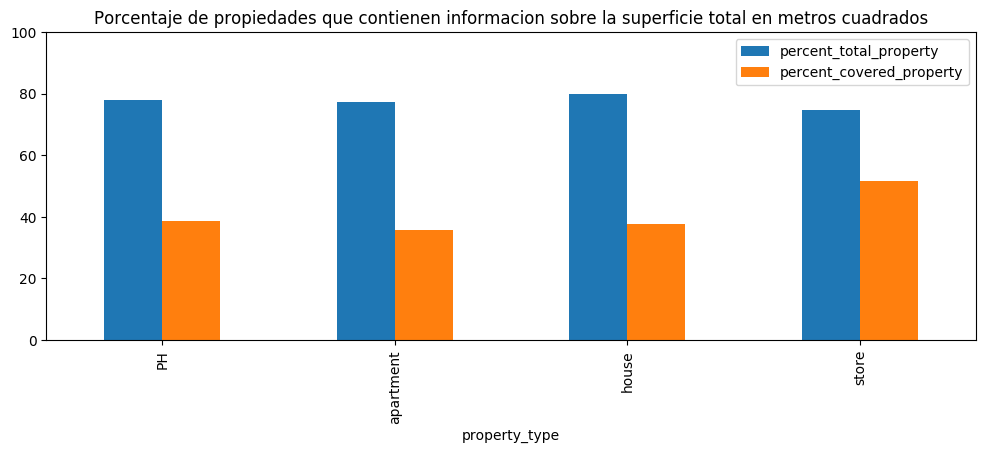

In [149]:
ax = plt.subplot()
ax.set_ylim(0,100)
property_with_surface_covered.plot.bar(ax = ax ,x='property_type',y=['percent_total_property','percent_covered_property']\
            ,title='Porcentaje de propiedades que contienen informacion sobre la superficie total en metros cuadrados')



El porcentaje de propiedades que cuenta con informacion de metros cuadrados es igual en los 'PH', 'apartment', y 'house' cerca de un 35%, a excepcion de 'store' que aumenta al 50%. Si bien las tiendas resaltan, esto se puede dever a que son las propiedades que menos cantidad hay por lo que estariamos siendo afectados por la maldicion de la dimensionalidad

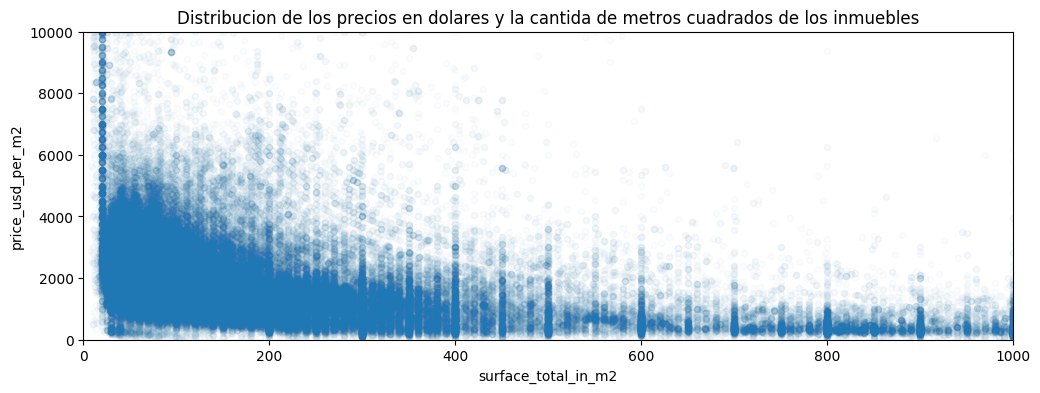

In [150]:
ax = plt.subplot()
ax.set_xlim(0,1000)
ax.set_ylim(0,10000)
price_sell_properati[ (price_sell_properati['surface_total_in_m2'] > 0) &( price_sell_properati['price_usd_per_m2'] > 0) ]\
                .plot.scatter(alpha=0.02,x='surface_total_in_m2',y='price_usd_per_m2',ax=ax,\
                title='Distribucion de los precios en dolares y la cantida de metros cuadrados de los inmuebles')

Podemos apreciar que la mayor concentracion de puntos se encuentran en la parte izquierda, por lo cual predominan las publicaciones con una superficie total en metros cuadrados bajos. A su vez podemos ver como hay una curva lo cual nos hace pensar que al disminuir cantidad de metros cuadrados en una propiedad, esto encarece el precio por metro cuadrado.

# Continuaremos trabajando con el set de datos completo para disponer de toda la informacion.

### Se agrega la superficie total de los inmbuebles que disponen del precio por metro cuadrado en dolares


In [151]:
sell_properati_filter = sell_properati

In [152]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2','price_aprox_usd','price']].count()

surface_total_in_m2    113437
price_usd_per_m2       235631
price_per_m2           126194
price_aprox_usd        351192
price                  351194
dtype: int64

In [153]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que no cuentan con este dato

In [154]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que no cuentan con dicha informacion

In [155]:
dataframe_calc_value(sell_properati_filter,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las pripiedades

In [156]:
dataframe_calc_value(sell_properati_filter,'price_per_m2','price','surface_total_in_m2')

In [157]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2']].mean()

surface_total_in_m2    7298.020592
price_usd_per_m2               inf
price_per_m2                   inf
dtype: float64

In [158]:
sell_properati_filter = sell_properati_filter[~((sell_properati_filter['surface_total_in_m2'] == 0 ) | \
                     (sell_properati_filter['price'] == 0 ))]

In [159]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2']].mean()

surface_total_in_m2    7402.093163
price_usd_per_m2       2268.710530
price_per_m2           3892.322905
dtype: float64

In [160]:
sell_properati_filter[(pd.notnull(sell_properati_filter['surface_total_in_m2']))]\
            [['surface_total_in_m2','price_usd_per_m2','price_per_m2','price_aprox_usd','price']].shape

(278094, 5)

In [161]:
sell_properati_filter.describe()

,floor,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,rooms,surface_covered_in_m2,surface_total_in_m2,year
count,63934.000000,3.134440e+05,309035.000000,309030.000000,3.459930e+05,3.459910e+05,3.459910e+05,2.703560e+05,2.703630e+05,234360.000000,1.353650e+05,2.780940e+05,387297.000000
mean,12.558169,3.498564e+06,-34.416792,-58.520810,3.198344e+05,2.661353e+06,2.316726e+05,3.892323e+03,2.268711e+03,2.693519,1.490827e+04,7.402093e+03,2015.105627
std,109.945503,4.453998e+05,3.137239,3.099551,7.274691e+05,4.425045e+06,3.521142e+05,1.736486e+04,9.810852e+03,1.429144,5.435967e+06,3.792575e+06,1.278601
min,0.000000,3.427208e+06,-89.999744,-122.419416,2.000000e+02,3.499999e+04,4.699600e+03,5.000000e-05,5.000000e-05,0.000000,0.000000e+00,1.000000e+00,2013.000000
25%,2.000000,3.429617e+06,-34.634607,-58.565634,9.800000e+04,9.102045e+05,9.350000e+04,1.385246e+03,1.214286e+03,2.000000,4.500000e+01,5.000000e+01,2014.000000
50%,3.000000,3.430786e+06,-34.598200,-58.469802,1.630000e+05,1.570852e+06,1.460000e+05,1.987179e+03,1.838710e+03,3.000000,7.500000e+01,8.200000e+01,2015.000000
75%,6.000000,3.435607e+06,-34.553369,-58.412401,3.200000e+05,2.940700e+06,2.590000e+05,2.750000e+03,2.452830e+03,3.000000,1.500000e+02,1.950000e+02,2016.000000
max,7071.000000,6.693230e+06,52.278850,164.531250,1.484420e+08,7.984250e+08,5.000000e+07,6.172050e+06,2.600000e+06,40.000000,2.000000e+09,2.000000e+09,2017.000000


 & (sell_properati_filter['price_usd_per_m2'] > 5000)

In [162]:
sell_properati_filter[sell_properati_filter['price_usd_per_m2'] < 1 ][['price','price_aprox_usd','price_usd_per_m2','price_per_m2','surface_total_in_m2']]

,price,price_aprox_usd,price_usd_per_m2,price_per_m2,surface_total_in_m2
120828,NaN,NaN,0.027027,NaN,NaN
120829,NaN,NaN,0.013514,NaN,NaN
120830,NaN,NaN,0.017544,NaN,NaN
146593,80000.0,80000.0,0.676155,0.676155,1.183160e+05
221035,80000.0,80000.0,0.676155,0.676155,1.183160e+05
229493,100000.0,100000.0,0.000050,0.000050,2.000000e+09
257221,80000.0,80000.0,0.676155,0.676155,1.183160e+05
309553,NaN,NaN,0.001992,NaN,NaN
449697,80000.0,80000.0,0.676155,677.966102,1.183160e+05
460130,62000.0,62000.0,0.062760,0.062760,9.878970e+05


(0, 5000)

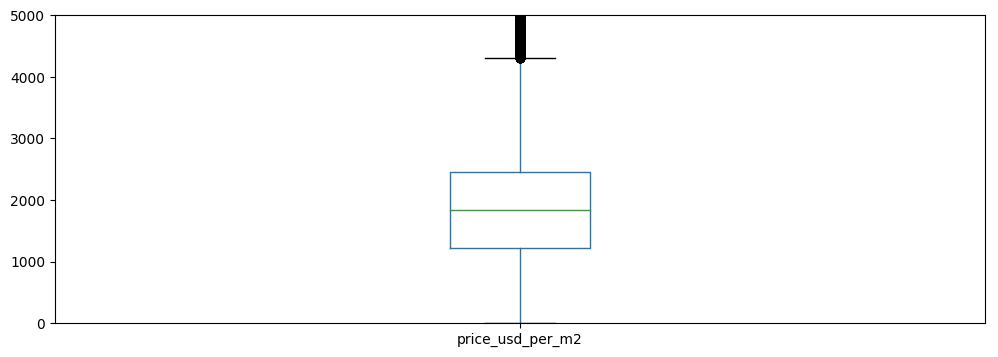

In [163]:
sup_lim = 5000
ax = plt.subplot()
sell_properati_filter.price_usd_per_m2.plot.box(ax=ax)
ax.set_ylim(0,sup_lim)

Vamos a filtrarlos datos que tengan precios entre entre USD 0 y USD 4.500 por metro cuadrado

(0, 600000)

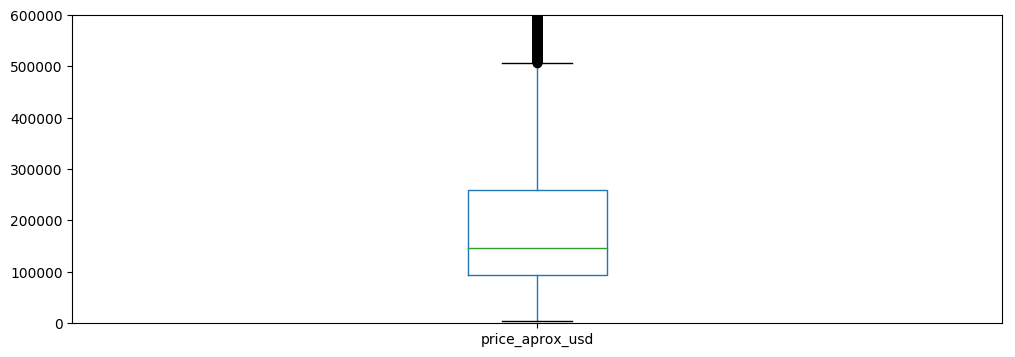

In [164]:
sup_lim = 600000
ax = plt.subplot()
sell_properati_filter.price_aprox_usd.plot.box(ax=ax)
ax.set_ylim(0,sup_lim)

Filtraremos los datos que tengan entre 0 y 550.000

(0, 800)

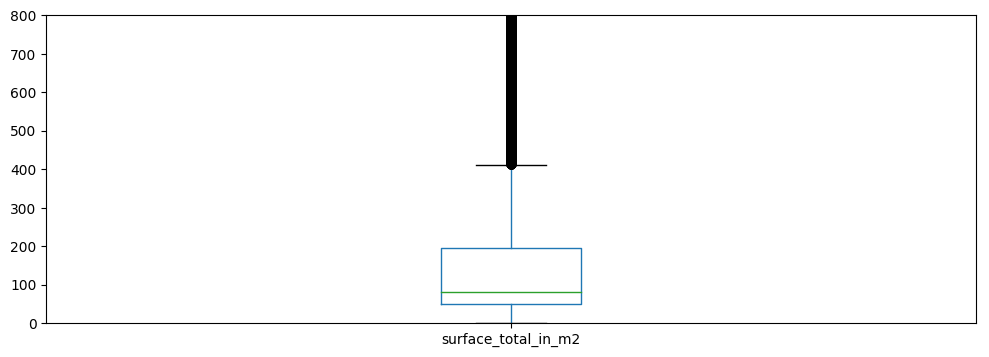

In [165]:
ax = plt.subplot()
sell_properati_filter.surface_total_in_m2.plot.box(ax=ax)
ax.set_ylim(0,800)

Filtraremos los datos que tengan una superficie total en metros cuadrados entre 0 y 800

In [166]:
filter_properati = sell_properati_filter[(sell_properati_filter['price_aprox_usd'] < 600000) &\
                                         (sell_properati_filter['price_usd_per_m2'] < 5000) & \
                                         (sell_properati_filter['surface_total_in_m2'] < 1000)]

In [172]:
float(filter_properati.shape[0]) / float(sell_properati.shape[0]) * 100

62.02927539329903

In [ ]:
sell_properati.

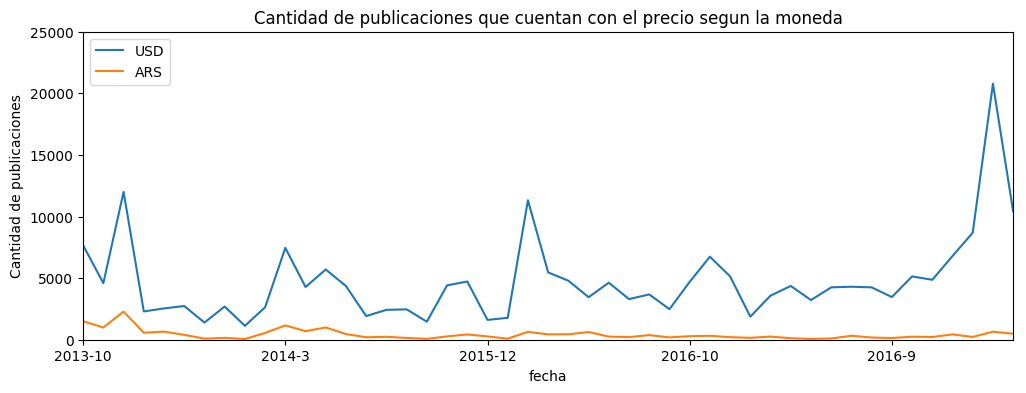

In [174]:
ax = plt.subplot()
filter_properati[filter_properati['currency'] == 'USD'].groupby(by='year_month').count().reset_index()\
    .plot.line(x='year_month',y='price',title='Cantidad de publicaciones que cuentan con el precio segun la moneda',ax=ax,legend=False)

filter_properati[filter_properati['currency'] == 'ARS'].groupby(by='year_month').count().reset_index()\
    .plot.line(x='year_month',y='price',ax=ax,legend=False)
ax.legend(['USD','ARS'])
ax.set_xlabel("fecha")
ax.set_ylim(0,25000)
ax.set_ylabel('Cantidad de publicaciones')

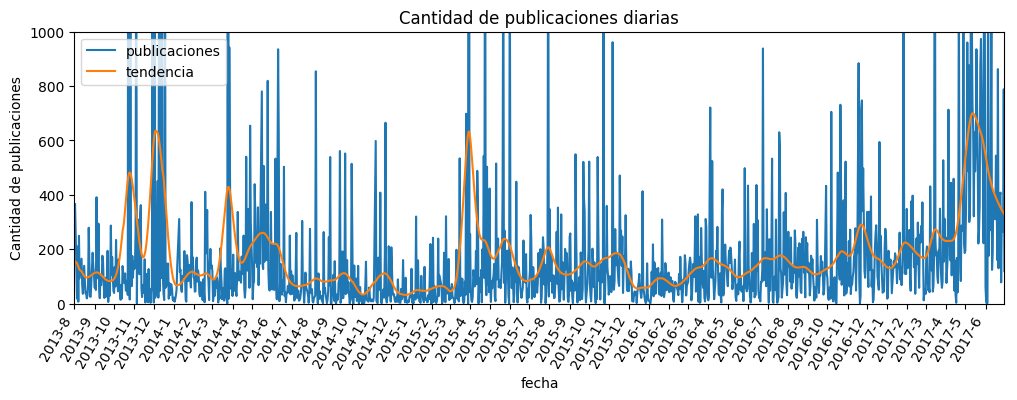

In [241]:
df = filter_properati.groupby(by='created_on').count().reset_index()

# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price, tend_price = sm.tsa.filters.hpfilter(df['price'])
df['tend_price'] = tend_price
ax=plt.subplot()
# graficando la variacion del precio real con la tendencia.
df.plot.line(ax=ax,x='created_on',y=['price','tend_price'],title='Precio de USD en ARS junto a su tendencia');
legend = plt.legend(['publicaciones','tendencia'])
ticks = df.created_on.apply(lambda x: str(x.year) + '-' + str(x.month)).unique()
ax.set_xticks(minor=False,ticks=ticks)
ax.set_xticklabels(labels=ticks,rotation=60)
ax.set_ylim(0,1000)

ax.set_xlabel("fecha")
ax.set_ylabel('Cantidad de publicaciones')
ax.set_title('Cantidad de publicaciones diarias')

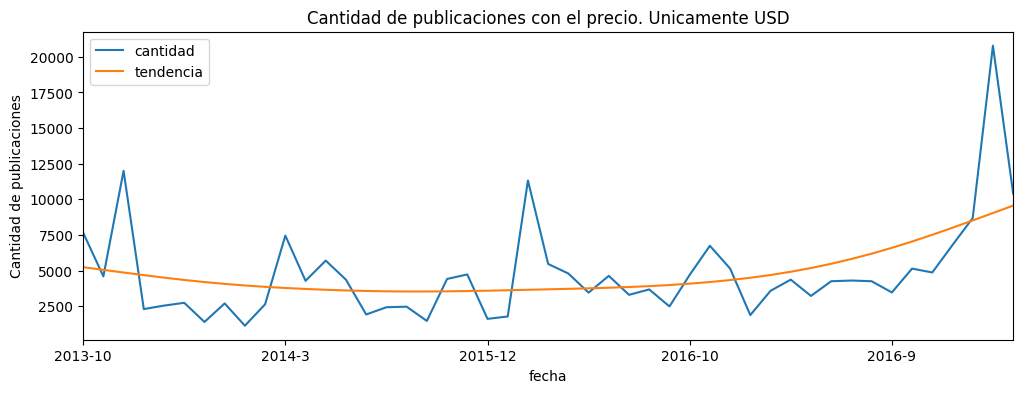

In [203]:
df = filter_properati[filter_properati['currency'] == 'USD'].groupby(by='year_month').count().reset_index()

# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price, tend_price = sm.tsa.filters.hpfilter(df['price'])
df['tend_price'] = tend_price
ax=plt.subplot()
# graficando la variacion del precio real con la tendencia.
df.plot(ax=ax,x='year_month',y=['price','tend_price'],title='Precio de USD en ARS junto a su tendencia');
legend = plt.legend(['cantidad','tendencia'])



ax.set_xlabel("fecha")
ax.set_ylabel('Cantidad de publicaciones')
ax.set_title('Cantidad de publicaciones con el precio. Unicamente USD')

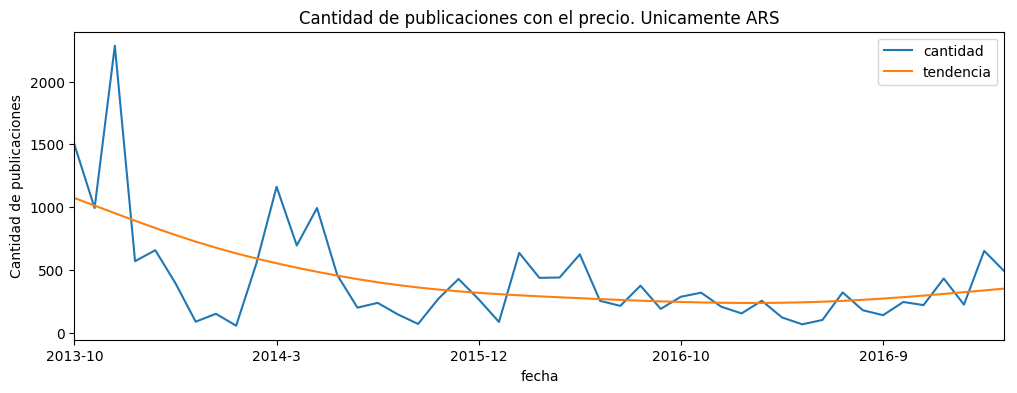

In [204]:
df = filter_properati[filter_properati['currency'] == 'ARS'].groupby(by='year_month').count().reset_index()

# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price, tend_price = sm.tsa.filters.hpfilter(df['price'])
df['tend_price'] = tend_price
ax=plt.subplot()
# graficando la variacion del precio real con la tendencia.
df.plot(ax=ax,x='year_month',y=['price','tend_price'],title='Precio de USD en ARS junto a su tendencia');
legend = plt.legend(['cantidad','tendencia'])



ax.set_xlabel("fecha")
ax.set_ylabel('Cantidad de publicaciones')
ax.set_title('Cantidad de publicaciones con el precio. Unicamente ARS')

###  Vamos a estimar el precio del dolar

In [205]:
estimate_dolar_price = filter_properati[filter_properati['currency'] == 'ARS'].groupby(by='year_month').mean().reset_index()

In [206]:
estimate_dolar_price = estimate_dolar_price[(estimate_dolar_price['price_usd_per_m2'] > 0)]

In [207]:
estimate_dolar_price = estimate_dolar_price[(estimate_dolar_price['price_per_m2'] > 0)]

In [209]:
estimate_dolar_price['dolar'] = estimate_dolar_price['price_per_m2'] / estimate_dolar_price['price_usd_per_m2']

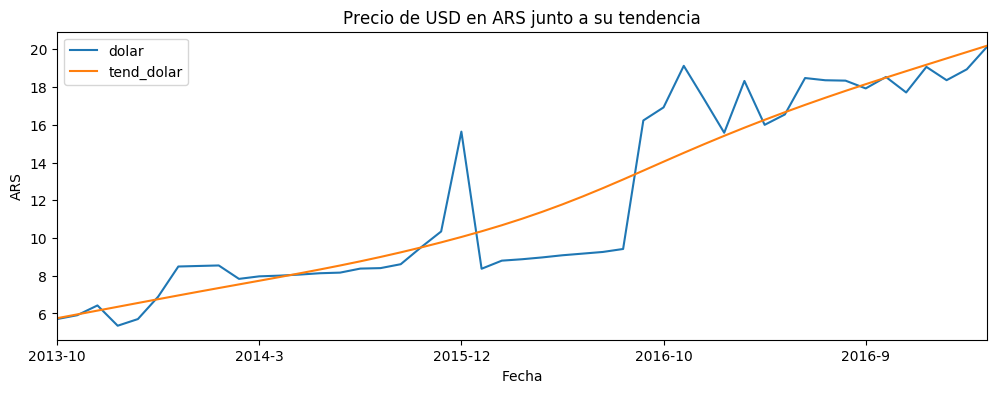

In [210]:
df = estimate_dolar_price

# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
dolar, tend_dolar = sm.tsa.filters.hpfilter(df['dolar'])
df['tend_dolar'] = tend_dolar
ax=plt.subplot()
# graficando la variacion del precio real con la tendencia.
df.plot(ax=ax,x='year_month',y=['dolar','tend_dolar'],title='Precio de USD en ARS junto a su tendencia');
legend = plt.legend()
ax.set_ylabel('ARS')
ax.set_xlabel('Fecha')

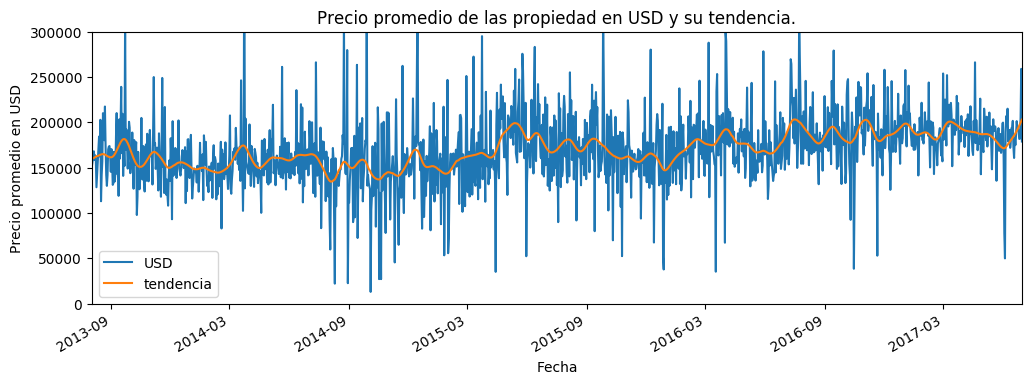

In [219]:
df = filter_properati.groupby(by='created_on').mean().reset_index()

# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price_aprox_usd, price_aprox_usd_tend = sm.tsa.filters.hpfilter(df['price_aprox_usd'])
df['tend'] = price_aprox_usd_tend
ax = plt.subplot()

df.plot(ax=ax,x='created_on',y=['price_aprox_usd','tend'])
ax.set_xlabel('Fecha')
ax.set_ylim(0,300000)
ax.set_ylabel('Precio promedio en USD')
ax.set_title('Precio promedio de las propiedad en USD y su tendencia.')
ax.legend(['USD','tendencia'])

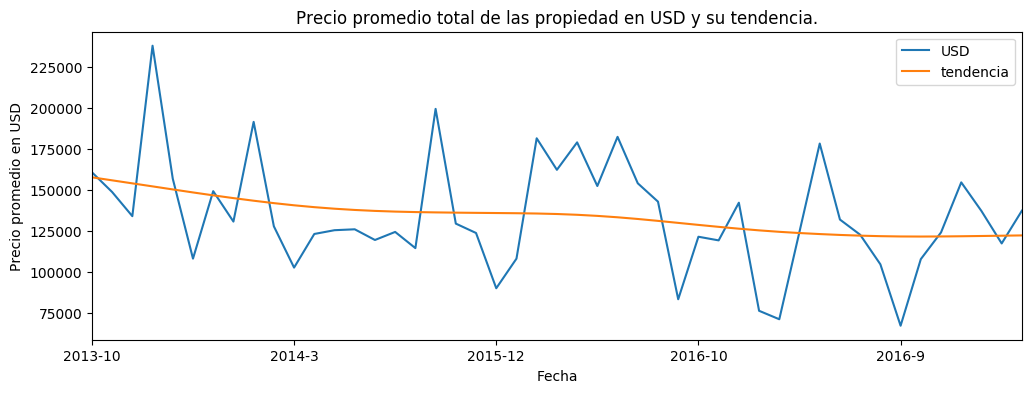

In [183]:
df = filter_properati[filter_properati['currency'] == 'ARS'].groupby(by='year_month').mean().reset_index()

# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price_aprox_usd, price_aprox_usd_tend = sm.tsa.filters.hpfilter(df['price_aprox_usd'])
df['tend'] = price_aprox_usd_tend
ax = plt.subplot()

df.plot(ax=ax,x='year_month',y=['price_aprox_usd','tend'])
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio promedio en USD')
ax.set_title('Precio promedio total de las propiedad en USD y su tendencia.')
ax.legend(['USD','tendencia'])

#### Sacando el promedio mensual de las publicaciones, pudimos ver como a travez del tiempo fueron evolucionando los precios de las propiedades. Es interesante ver como la variacion es muy pequeña (siguiendo la linea de tendencia) en el intervalo de años que estamos trabajando. 

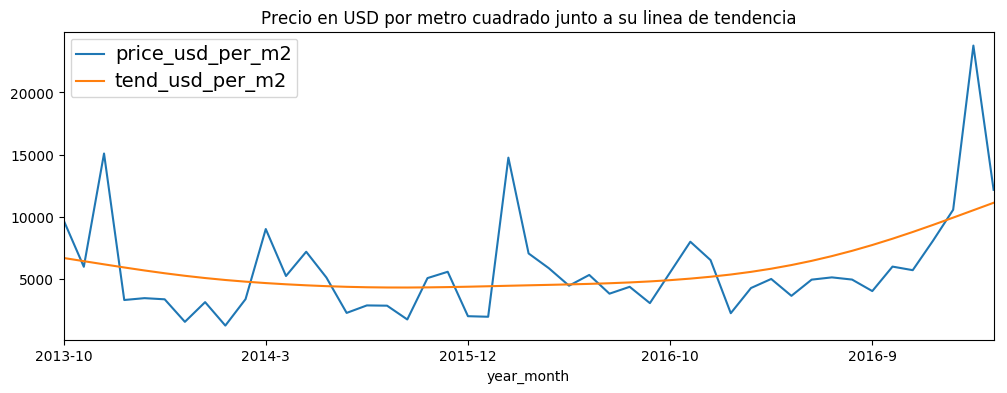

In [193]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price_usd_per_m2, pride_usd_per_m2_tend = sm.tsa.filters.hpfilter(df['price_usd_per_m2'])
df['tend_usd_per_m2'] = pride_usd_per_m2_tend

# graficando la variacion del precio real con la tendencia.
df.plot(x='year_month',y=['price_usd_per_m2','tend_usd_per_m2'],title='Precio en USD por metro cuadrado junto a su linea de tendencia');
legend = plt.legend()
legend.prop.set_size(14);



Tanto el precio en USD por metro cuadrado, como por propiedad va bajando a medida que pasa el tiempo, ¿que es lo que pasa con el precio en ARS?

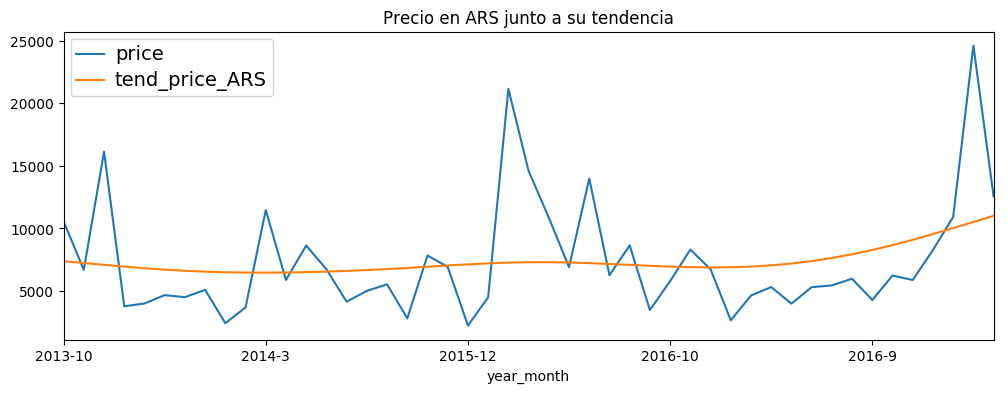

In [194]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
price, tend_price_ARS = sm.tsa.filters.hpfilter(df['price'])
df['tend_price_ARS'] = tend_price_ARS

# graficando la variacion del precio real con la tendencia.

df.plot(x='year_month',y=['price','tend_price_ARS'],title='Precio en ARS junto a su tendencia');
legend = plt.legend()
plt.axis()
legend.prop.set_size(14);



In [ ]:
sell_properati_filter.price_aprox_usd.min()

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment']\
.plot.bar(x='rooms',y='price_usd_per_m2',title='Precio del metro cuadrado en dolares promedio, de los departamentos segun la cantidad de ambintes')

In [ ]:
sell_properati[sell_properati['property_type'] == 'house'].groupby(by='rooms').std().reset_index()\
.plot.bar(x='rooms',y='price_usd_per_m2',title='Precio del metro cuadrado en dolares promedio de las casas segun la cantidad de ambientes')

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment'].groupby(by='floor').mean().reset_index()\
.plot.bar(x='floor',y='price_usd_per_m2',title='Precio promedio de un departamento segun el piso en el cual se encuentra')

Esta imagen muestra la anomalia en cuanto al piso en el cual se encuentra un departamento, por lo cual se decidio ver mas en profundidad cuales son los numeros de habitaciones que hay en este set de datos

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment'].floor.describe()

In [ ]:
sell_properati[sell_properati['property_type'] == 'apartment'].floor.unique().astype(int)

Como se puede ver, es muy extraño este patron ya que hay "aparment" que se encuentran en el piso 2509 lo cual implica que haya algun edificio con esa cantidad de pisos en la ciudad o el gran buenos aires.

# Lista de pendiente
###    ·Agregar informacion sobre el transporte y visualizar cual es la influencia de estos en el precio, teniendo en cuenta la distancia
###    ·Agregar informacion sobre los espacios verdes y visualizar el efecto de estos en el precio de las propiedades
